# Annual Business Survey 2019
## Group Assessment - Module 08

  *****

## ETL Report
### Introduction

- In this portion, we will dicuss the problems or questions that we are trying to solve or answer. 
    We will identify the sources of our data and describe why the data needs to be transformed.
    
The United States Census Bureau provides access to an extensive database with hundreds of datasets that detail national <br>
  characteristics. The data is stored in a way that can be quite confusing to many people, but there are many resources to <br>
  assist interested researchers with gleaning new insights from the data.
  
For this study, we looked specifically at the Annual Business Survey for **2019** which examines data from **2018**. This survey <br>
  provides information on a variety of characteristics for businesses and business owners.
  
**These are the questions that we are focusing on:**<br>
> 1. When considering the Finance and Insurance Industries as well as the Education Industry, what are the reasons that a owner <br>
      was motivated to create the business?
      
> 2. When considering the highest average pay for each state, are there any noticeable trends when accounting for the Industry, <br>
      the Race of the Owner, or the Gender of the Owner?

> 3. What are some of the most popular tech solutions in Minnesota?
    
> 4. What questions are business owners most likely to respond to?

> 5. Is there a gender gap among business owners based on race?

> 6. Is there significant variance in new businesses across the country, and if so, which states have a higher portion of new businesses?

> 7. For the states with the highest contrast in portion of new businesses, which categories with years in business are making up the difference?

> 8. Which industries have the highest portion of new businesses, and does this help explain location variance?

> 9. What trends are there in the ownership of firms by gender, and is it significantly different across industries?

> 10. What are the trends for ownership of firms by racial group, and how does this compare to overall US demographics?


**Why is it important to transform the data?**<br>

As mentioned previously, the data is stored in a way that can be quite confusing, and it is necessary to perform a variety of<br>
  transformations on it before it can be utilized. Some things to keep in mind is that there are multiple series of "total" categories,<br>
  multiple variables stored in a single column, and the call to the API must contain every needed variable, as well as supporting variables<br>
  in order to get complete and accurate results.
### Data Sources

The data used in this study was gathered directly from the U.S. Census Bureau data API. 

>US Census Bureau. (2021b, October 14). *Annual Business Survey (ABS) APIs.* Census.Gov.<br>
>Retrieved April 22, 2022, from https://www.census.gov/data/developers/data-sets/abs.2019.html

### Extraction

- In this portion we will show how we got our data, show aspects of the data consumption process and indicate the order of the process.
**Step 1 - Import Modules**
> In this step, we are gathering all the modules that will be used in the script. We have also included a helper module that can act <br>
as a variable dictionary for someone seeking to understand the code.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt

import matplotlib.pyplot as plt
import plotly.express as px

from textwrap import wrap
from utils import explain # Helper for clarifying variable information (for questions about this, type "help(explain)" in a cell)


 ----- HELPER MODULE IMPORTED ------

    For information on the helper module:
        run 'help(explain)' in any cell. 
        
    To directly use:
        run 'explain.what_is()' with no parameters.
    


**Step 2 - Get Variable Tables**
> In this step, we gathered the variables from each of the available datasets, and merged them into a single table with a goal<br>
of understanding what data was available in each table, and if there were any common variables between tables.

> To read this data into a dataframe we used the Pandas **"read_html()"** method which returns a list of all tables that are<br>
that are available at the target source. We then kept only the first two columns from each table and renamed a column<br>
that would cause name conflicts in a merged dataframe.

In [2]:
var_links = [
    'https://api.census.gov/data/2018/abstcb/variables.html',
    'https://api.census.gov/data/2018/abscbo/variables.html',
    'https://api.census.gov/data/2018/abscb/variables.html',
    'https://api.census.gov/data/2018/abscs/variables.html'
]

# Get the tables of variables.
tech_vars = pd.read_html(var_links[0])[0]
owner_vars = pd.read_html(var_links[1])[0]
characteristic_vars = pd.read_html(var_links[2])[0]
company_summary_vars = pd.read_html(var_links[3])[0]

# Keep only two columns from each table and rename columns for merge.
tech_vars = tech_vars.iloc[:,:2
                        ].rename(columns = {'Label': 'Tech Labels'})

owner_vars = owner_vars.iloc[:,:2
                        ].rename(columns = {'Label': 'Owner Labels'})

characteristic_vars = characteristic_vars.iloc[:,:2
                        ].rename(columns = {'Label': 'Characteristic Labels'})

company_summary_vars = company_summary_vars.iloc[:,:2
                        ].rename(columns = {'Label': 'Company Summary Labels'})

**Step 3 - Merge Variable Tables**
> In this step we merged all the variable tables using a full outer merge so that all records would<br>
be retained. We also filled all the null cells that were generated in the merge with "-" so that the<br>
table would be easier to read.

In [3]:
grouped_tables = pd.merge(
    tech_vars, owner_vars, left_on = 'Name', right_on = 'Name', how = 'outer'
)

grouped_tables = pd.merge(
    grouped_tables, characteristic_vars, left_on = 'Name', right_on = 'Name', how = 'outer'
)

grouped_tables = pd.merge(
    grouped_tables, company_summary_vars, left_on = 'Name', right_on = 'Name', how = 'outer'
)

grouped_tables.fillna("-", inplace = True)
grouped_tables = grouped_tables[(~grouped_tables['Name'].str.endswith('_S'))]

grouped_tables = grouped_tables[:-2].sort_values(by = 'Name')
grouped_tables = grouped_tables[(~grouped_tables['Name'].str.contains('variables'))]

**Step 4 - Group Similar Variables**
> This step was necessary because some of the variables referenced the same metric<br>
but were named slightly differently. For example, OWNER_ETH vs. ETH_GROUP. 

> We then ordered the generated table by column and by name to prepare it for<br>
further use.

> We created a smaller table from this generated table that consisted only of<br>
the variables that were present in all datsets. This was done in an effort to<br>
reduce the ambiguity of the datasets and inform a merge of all datasets.

In [4]:
def clean_var_names(var_name):
    """ This function assists with grouping similar variables """
    if 'OWNER_' in var_name:
        var_name = var_name.replace('OWNER_',"")
    elif ('OWN' in var_name and 'CHAR' not in var_name and 'PDEMP' not in var_name):
        var_name = var_name.replace('OWN',"")
    
    if var_name in ['ETH','RACE','SEX','VET']:
        var_name = var_name + "_GROUP"
        
    return var_name

grouped_tables['Common_Vars'] = grouped_tables['Name'].apply(clean_var_names)
grouped_tables = grouped_tables[
    ['Name','Common_Vars','Tech Labels','Owner Labels',
     'Characteristic Labels','Company Summary Labels']
]

grouped_tables.sort_values(
    by = 'Common_Vars').reset_index(drop = True, inplace = True)

# Create smaller dataframe that just contains variables present in all tables.
possible_merge_options = grouped_tables[
    (grouped_tables['Common_Vars'].str.contains("SEX|RACE|ETH|VET")) | 
    (grouped_tables.apply(lambda x: not x.str.contains("-").any(), axis = 1))
].sort_values(by = 'Common_Vars').reset_index(drop = True)

# This list contains all variables that were found in the possible_merge_options.
common_vars = [_.lower() for _ in possible_merge_options.Common_Vars.unique().tolist()]

**The cell below is intended for viewing the generated dataframes.**

In [5]:
#possible_merge_options
#grouped_tables.reset_index(drop = True)

**Step 5 - Define which variables will be requested from API**
> After reviewing the available end points as well as encountering various errors<br>
or missing information, we settled on a list of variables that we were interested in<br>
and isolated those variables and the tables they were in from our grouped tables. 

In [6]:
vars_of_interest = [
    'NAICS2017',
    'YIBSZFI',
    'SEX',
    'QDESC',
    'NSFSZFI',
    'GEO_ID',
    'RACE_GROUP',
    'BUSCHAR',
    'OWNER_RACE',
    'OWNER_SEX',
    'OWNPDEMP',
    'FIRMPDEMP',
    'OWNCHAR',
    'TECHUSE',
    'RCPPDEMP',
    'PAYANN',
    'EMP'
]

target_subset = grouped_tables[(grouped_tables['Name'].isin(vars_of_interest))]
target_subset = target_subset[['Name','Company Summary Labels','Characteristic Labels','Owner Labels','Tech Labels']]

**Step 6 - Build variable strings for api calls**
> In this step, we used our table of variables and which datasets those variables were available in<br>
and generated end point strings to pass into the api call. We used a for loop to generate a dictionary<br>
of end point strings. We also added the "_LABEL" to any of the endpoints that had that option available.

In [7]:
no_label = [
    'OWNPDEMP_LABEL','GEO_ID_LABEL','FIRMPDEMP_LABEL','STATE_LABEL','PAYANN_LABEL',
    'EMP_LABEL','RCPPDEMP_LABEL',
]
variable_dict = {}
for i,label in enumerate(target_subset.columns[1:]):
    variable_list = []
    for item in target_subset[(target_subset[label] != "-")].Name.tolist():
        variable_list.append(item)
        variable_list.append(f'{item}_LABEL')
    variable_list = [_ for _ in variable_list if _ not in no_label]
    in_table = "NAME," + ",".join(variable_list)
    variable_dict[i] = in_table

**Step 7 - Request Data from API**
> Using the dictionary of variable strings that was created in step 6, we generated links for each of the datasets and<br>
requested the data from the api. For each call to the api, we printed the url that was passed so that we could easily<br>
troubleshoot any errors. The final step was to create a list of all the dataframe that would be iterated through for cleaning them.

In [8]:
links = [
    f'https://api.census.gov/data/2018/abscs?get={variable_dict[0]}&for=state:*',
    f'https://api.census.gov/data/2018/abscb?get={variable_dict[1]}&for=state:*',
    f'https://api.census.gov/data/2018/abscbo?get={variable_dict[2]}&for=us:*&for=QDESC_LABEL=YRACQBUS',
    f'https://api.census.gov/data/2018/abstcb?get={variable_dict[3]}&for=state:*',
    f'https://api.census.gov/data/2018/abscbo?get={variable_dict[2]}&for=state:*&OWNCHAR=CG&NAICS2017=00&QDESC=O02',
    f'https://api.census.gov/data/2018/abscs?get={variable_dict[0]}&for=us:*' #<-Jed removed extra variable from here
]

def get_data_frame(url):
    print("If the operation fails, click the link to see the error.")
    print(url,'\n')
    return pd.read_csv(url)

comp_sum_df = get_data_frame(links[0]) # Company Summary
bus_char_df = get_data_frame(links[1]) # Business Characteristics
bus_own_df = get_data_frame(links[2]) # Business Owners (National Level)
bus_tech_df = get_data_frame(links[3]) # Business Tech   
slbo = get_data_frame(links[4]) # Business Owners (State Level)
comp_sum_natl_df = get_data_frame(links[5]) #Company Summary National

If the operation fails, click the link to see the error.
https://api.census.gov/data/2018/abscs?get=NAME,EMP,FIRMPDEMP,GEO_ID,NAICS2017,NAICS2017_LABEL,PAYANN,RACE_GROUP,RACE_GROUP_LABEL,RCPPDEMP,SEX,SEX_LABEL,YIBSZFI,YIBSZFI_LABEL&for=state:* 

If the operation fails, click the link to see the error.
https://api.census.gov/data/2018/abscb?get=NAME,BUSCHAR,BUSCHAR_LABEL,EMP,FIRMPDEMP,GEO_ID,NAICS2017,NAICS2017_LABEL,PAYANN,QDESC,QDESC_LABEL,RACE_GROUP,RACE_GROUP_LABEL,RCPPDEMP,SEX,SEX_LABEL,YIBSZFI,YIBSZFI_LABEL&for=state:* 

If the operation fails, click the link to see the error.
https://api.census.gov/data/2018/abscbo?get=NAME,GEO_ID,NAICS2017,NAICS2017_LABEL,OWNCHAR,OWNCHAR_LABEL,OWNER_RACE,OWNER_RACE_LABEL,OWNER_SEX,OWNER_SEX_LABEL,OWNPDEMP,QDESC,QDESC_LABEL&for=us:*&for=QDESC_LABEL=YRACQBUS 

If the operation fails, click the link to see the error.
https://api.census.gov/data/2018/abstcb?get=NAME,EMP,FIRMPDEMP,GEO_ID,NAICS2017,NAICS2017_LABEL,NSFSZFI,NSFSZFI_LABEL,PAYANN,RACE_GRO

In [9]:
df_collection = [comp_sum_df, bus_char_df, bus_own_df, bus_tech_df, slbo, comp_sum_natl_df]
df_names = ['comp_sum_df', 'bus_char_df', 'bus_own_df', 'bus_tech_df','slbo', 'comp_sum_natl_df']   

### Transformation
> Once we had gathered the datasets that we were interested in, we needed to clean the data<br>
so that it could be useful for analysis. 

> We first created a list of columns that could be dropped. These were present because they were<br> 
required for the actual call in order to get a related column.

> We then iterated through our collection of dataframes and cleaned columns that had artifacts from<br>
the method of the api call. 

> Finally, we renamed some ambiguous columns so that their contents would be more clear.


In [10]:
drop_list = [
    'race_group','sex','yibszfi','qdesc','buschar',
    'owner_race','owner_sex','us','ownchar'
]

for df in df_collection:
    column_names = [_ for _ in df.columns.tolist()]
    new_column_names = [
        _.replace("[[","")
         .replace('"',"")
         .replace("]","")
         .lower() for _ in column_names
    ]

    df.columns = new_column_names
    df.drop(columns = [_ for _ in new_column_names if ('unnamed' in _ or _ in drop_list)],inplace = True)
    df['name'] = df['name'].apply(lambda x: x.replace("[","").replace('"',""))
    
    if 'sex_label' in df.columns:
        df.rename(columns = {'sex_label': 'gender'}, inplace = True)
    
    if 'owner_sex_label' in df.columns:
        df.rename(columns = {'owner_sex_label': 'gender'}, inplace = True)
    
    if 'naics2017_label' in df.columns:
        df.rename(columns = {'naics2017_label': 'industry'}, inplace = True)
        
    if 'naics2017' in df.columns:
        df.rename(columns = {'naics2017': 'industry_code'}, inplace = True)

### Display some info about dataframes and save data
- This looks a little rough, but that is because it was used to assist in understanding the data<br>
    but it has no utility for the general analysis.

In [11]:
def inform():
    for i,df in enumerate(df_collection):
        # try:
        #     df.to_csv(f'data/{df_names[i]}.csv', index = False)
        # except:
        #     print("Data directory is not present - skipping save")

        print('\n############# NEW DATAFRAME ################')
        print('Displaying column value counts where there are fewer than 10 unique values in the column.')
        print(f'\n---  DataFrame: {df_names[i]} ---------------------')
        print(f'Columns: {", ".join(df.columns.tolist())}\n')
        for column in df:
            unique_values = len(df[column].unique().tolist())
            if (unique_values < 30 and unique_values > 1):
                print(df[column].value_counts())
                print("")
        print('############# END OF DATAFRAME INFO ################\n\n')
# inform() # Remove comment to display basic information about the data.

## All Tables Merge
 - We certainly had a substantial amount of difficulty with this merge because it was difficult to find ways<br>
     that the the data could be useful when fully merged. <br><br> 
     In this merge set, we are looking at the level of artificial intelligence in all sectors in Minnesota, <br>
     and how it relates to how long the company has been in business, and whether it is a family owned business.

### Steps:

1. Limit table data to "Total for all sectors".

In [12]:
total_bus_tech_df = bus_tech_df[(bus_tech_df['industry'] == 'Total for all sectors')]
total_bus_own_df = bus_own_df[(bus_own_df['industry'] == 'Total for all sectors')]
total_comp_sum_df = comp_sum_df[(comp_sum_df['industry'] == 'Total for all sectors')]
total_bus_char_df = bus_char_df[(bus_char_df['industry'] == 'Total for all sectors')]
total_slbo = slbo[(slbo['industry'] == 'Total for all sectors')]

2. Further filter the table data and remove unnecessary columns.

In [13]:
robotics_in_mn = total_bus_tech_df[(~total_bus_tech_df['techuse_label'].str.contains('Total')) & (total_bus_tech_df['name'] == 'Minnesota') & (total_bus_tech_df['techuse_label'].str.contains('Artificial'))]
robotics_in_mn = robotics_in_mn[['name','techuse_label','firmpdemp']]

years_in_biz_mn = total_comp_sum_df[(total_comp_sum_df.name == 'Minnesota') & (total_comp_sum_df['yibszfi_label'] != 'All firms') & (total_comp_sum_df['gender'] != 'Total')]
years_in_biz_mn = years_in_biz_mn[['name','gender','yibszfi_label','firmpdemp']].drop_duplicates()

bus_char_mn = total_bus_char_df[(total_bus_char_df.name == 'Minnesota') & (total_bus_char_df['buschar_label'] != 'All firms')& (total_bus_char_df['buschar_label'] != 'Total reporting') & (total_bus_char_df['qdesc_label'] == 'FAMOWN')]
bus_char_mn = bus_char_mn[['name','qdesc_label','buschar_label','firmpdemp']]

total_slbo = total_slbo[(total_slbo.name == 'Minnesota')]
total_slbo = total_slbo[['name','ownchar_label','ownpdemp']]

3. Rename similar columns so that they are meaningfull after the merge.

In [14]:
years_in_biz_mn.rename(columns = {'firmpdemp': 'yib_num_firms'}, inplace = True)
robotics_in_mn.rename(columns = {'firmpdemp': 'robin_mn_num_firms'}, inplace = True)
bus_char_mn.rename(columns = {'firmpdemp': 'bus_char_num_firms'}, inplace = True)

4. Merge tables using outer merge to retain all records.

In [15]:
joined_tables = pd.merge(years_in_biz_mn, robotics_in_mn, left_on = 'name', right_on = 'name', how = 'outer')
joined_tables = pd.merge(joined_tables, bus_char_mn, left_on = 'name', right_on = 'name', how = 'outer')
joined_tables = pd.merge(joined_tables, total_slbo, left_on = 'name', right_on = 'name', how = 'outer')

# Just to display a subset of the data
joined_tables.iloc[[_ for _ in range(1870,1876)]]

,name,gender,yibszfi_label,yib_num_firms,techuse_label,robin_mn_num_firms,qdesc_label,buschar_label,bus_char_num_firms,ownchar_label,ownpdemp
1870,Minnesota,Equally male/female,Firms with less than 2 years in business,0,Artificial Intelligence: Don't know,4105,FAMOWN,Item not reported,2293,Before 1980,3210
1871,Minnesota,Equally male/female,Firms with less than 2 years in business,0,Artificial Intelligence: Don't know,4105,FAMOWN,Not applicable,3158,Before 1980,3210
1872,Minnesota,Equally male/female,Firms with 16 or more years in business,272,Artificial Intelligence: Did not use,95053,FAMOWN,Family-owned,17863,Before 1980,3210
1873,Minnesota,Equally male/female,Firms with 16 or more years in business,272,Artificial Intelligence: Did not use,95053,FAMOWN,Not family-owned,40870,Before 1980,3210
1874,Minnesota,Equally male/female,Firms with 16 or more years in business,272,Artificial Intelligence: Did not use,95053,FAMOWN,Item not reported,2293,Before 1980,3210
1875,Minnesota,Equally male/female,Firms with 16 or more years in business,272,Artificial Intelligence: Did not use,95053,FAMOWN,Not applicable,3158,Before 1980,3210


****
# Analysis and Visualizations
> This section contains the code that was used to further transform the data as needed<br>
for visualizations and build visualizations.

### Jed's Visual Creation Code

In [16]:
def jeds_visuals():
    today = dt.datetime.strftime(
        dt.datetime.today().date(), '%b %d, %Y'
    )
    
    state_code_path = 'https://raw.githubusercontent.com/jedc4xer/abs_group_assessment/main/data/state_codes.csv'
    state_codes = pd.read_csv(state_code_path)
     
    def clean_data_stacked_bar():
        """ This function prepares the data for the stacked bar chart. """

        reason_owned = bus_own_df.copy()

        # Filter the data so that only the required data is present.
        reason_owned = reason_owned[
            (reason_owned['qdesc_label'] == 'REASONOWN') &
            (~reason_owned['industry'].str.contains('Total')) &
            (~reason_owned['gender'].str.contains('All')) &
            (reason_owned['ownchar_label'].str.contains(':'))
        ]

        # Split the 'reason for owning' label into two distinct columns.
        reason_owned[['reason','importance']] = reason_owned.apply(
            lambda row: row['ownchar_label'
                           ].split(":"), axis = 1, result_type = 'expand'
        )

        #grouped_reason = reason_owned.copy()

        # Calculate the total number of responses per reason.
        reason_owned = reason_owned.groupby(
            by = ['industry','reason','importance'])[['ownpdemp']].agg(
            responses = ('ownpdemp', 'sum')
        )

        # Calculate the ratio of reasons that a business was owned.
        reason_owned['ratio'] = (100 * (
            reason_owned['responses'] / reason_owned.groupby(
                level = [0,1])['responses'].transform('sum'))
        ).round(2)

        reason_owned.reset_index(inplace = True)

        subset = reason_owned.copy()

        # Filter the data to include only the target industries.
        subset = subset[
            (subset['industry'].str.contains('inanc|ducati'))
        ]

        # Sort the data to prepare it for display.
        subset.sort_values(
            by = ['importance','ratio'], ascending = False, inplace = True
        )

        # Rename columns to prepare for display.
        subset.rename(columns = {'ratio': 'Percent of Total'}, inplace = True)

        # Modify the category names so that they will fit between charts.
        reasons = subset.reason.unique().tolist()
        longest_reason = len(max(reasons, key = len))
        new_reasons = {}
        for reason in reasons:
            old_reason = reason
            while len(reason) < longest_reason - 2:
                reason = " " + reason + " "
            if len(old_reason) < 10:
                reason = " " + reason
            new_reasons[old_reason] = reason

        subset['reason'] = subset['reason'].apply(lambda x: new_reasons[x])
        return subset

    def stacked_bar():
        """ This function transforms the data and then builds a stacked bar plot. """

        stacked_bar_subset = clean_data_stacked_bar()
        
        fig = px.bar(stacked_bar_subset,
                     x = 'Percent of Total',
                     y = 'reason',
                     color = 'importance',
                     width = 1300, height = 600,
                     orientation = 'h',
                     hover_data = ['reason','responses'],
                     text = 'Percent of Total',
                     facet_col = 'industry',
                     facet_col_spacing=0.14
                )

        fig.update_layout(
            title = 'Reasons for Starting a Company',
            yaxis_title = None,
            title_y = .98,
            title_x = 0.003,
            title_font_size = 22,
            xaxis_title = "Percent of Total", 
            uniformtext_minsize = 13,
            uniformtext_mode = 'hide', 
            paper_bgcolor = 'white', 
            plot_bgcolor = 'white',
            hoverlabel = dict(
                bgcolor = 'white',
                bordercolor = 'black',
                font_size = 14,
                font_color = 'black'
            ),
            legend = dict(
                orientation = 'h',
                x=0,y=1.15,
                font = dict(size=13)
            )
        )

        fig.update_traces(
            textposition = 'inside', 
            insidetextanchor = 'middle',
            textfont = {'color': 'white'}
        )

        fig.update_yaxes(side = 'right')
        fig.update_xaxes(ticks = 'outside')
        fig.update_layout(
            margin={"r":0,"t":90,"l":0,"b": 90}, dragmode = False
        )

        fig.for_each_annotation(
            lambda a: a.update(text=a.text.split("=")[1])
        )

        fig.add_annotation(
                text = (
                    f"Created by: Jed Dryer | {today} | Source: US Census - 2019 ABS"
                ),
                showarrow=False,
                x = .70,
                y = -.19,
                xref='paper',
                yref='paper' ,
                xanchor='left',
                yanchor='bottom',
                xshift=-1,
                yshift=-3,
                font=dict(size=10, color="grey"),
                align="right",
                )
        fig.write_html('visuals/stacked_reasons.html')
        print("Jed's Stacked Bar Chart Successfully exported to HTML - Filename: 'stacked_reasons.html'")

    
    def build_bar_chart():
        """ This function builds a simple bar chart and saves it to a file. """
        
        # Get a subset of the business tech_df.
        subset = bus_tech_df[
            (bus_tech_df['industry'] == 'Total for all sectors'
            )
        ][['name','firmpdemp','techuse_label']]
        
        # Split the technology label into two distinct columns and then filter.
        subset[['tech','usage']] = subset.apply(
            lambda row: row['techuse_label'].split(":"), axis = 1, result_type = 'expand'
        )
        subset = subset[(subset['usage'].str.contains('Total R|High'))]
        subset = subset[(subset['name']) == 'Minnesota'][['firmpdemp','tech','usage']]
        
        # Transform and aggregate data to determine total respondents and the rate of use.
        subset['total_respondents'] = subset.groupby(
            by = ['tech']
        )['firmpdemp'].transform('max')
        subset = subset[(subset['usage'].str.contains('High use'))]
        subset['rate_of_high_use'] = 100 * (subset['firmpdemp'] / subset['total_respondents'])
        
        # Sort data for display.
        subset.sort_values(by = 'rate_of_high_use', ascending = False, inplace = True)

        # Build the plot.
        fig = plt.figure(figsize = (18,5))

        plt.title('Popular Tech Solutions in Minnesota', fontsize = 20, loc = 'left')
        ax = sns.barplot(data = subset, x = 'rate_of_high_use', y = 'tech', palette = 'flare',
                        edgecolor = 'grey')
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_yticklabels(ax.get_yticklabels(), size = 12)
        ax.tick_params(bottom = False)
        for c in ax.containers:
            labels = []
            for v in c:
                if (h := v.get_width()) > 14:
                    lab = f'{(h/100)*100:0.1f}% of reporting companies'
                elif (h := v.get_width()) > .8:
                    lab = f'{(h/100)*100:0.1f}%'
                else:
                    lab = f'{" "*16}- {(h/100)*100:0.2f}%'
                labels.append(lab)

            ax.bar_label(c,labels=labels,label_type = 'center',fontsize = 18,color= 'black', weight = 'bold')
        ax.set(xticklabels = [])
        sns.despine(left = True, bottom = True)
        
        # Save the figure and return None
        fig.savefig('visuals/pop_tech.png')
        plt.close()
        print("Jed's Bar Chart Built and Saved -- Filename: 'pop_tech.png'")
    
    def clean_for_map(df, target):
        """ This function cleans the data for use in a map. """
        
        # This matches the correct label based on the target
        label = {
            'gender': 'Owner Gender',
            'race_group_label': 'Owner Race',
            'industry':'Industry'
        }[target]
        
        # Filter the data
        subset = df[
            (df.payann != 0) & (df.gender != 'Total') & 
            (df.race_group_label != 'Total') & 
            (df.industry_code != '00')
        ]
        
        # Get a subset of the data and calculate average pay.
        subset = subset[['name','geo_id',target,'payann','firmpdemp','emp']]
        subset['payann'] = subset['payann'] * 1000
        subset['avg_pay'] = subset.apply(
            lambda row: row.payann/row.emp, axis = 1
        )

        # Determine the maximum average pay.
        subset_agg = subset.groupby(
            by = ['name'])[['avg_pay']].agg(max_pay = ('avg_pay','max'))

        subset_agg.reset_index(inplace = True)

        grouped = pd.merge(
            subset, subset_agg, left_on = 'name', right_on = 'name', how = 'left'
        )

        grouped = grouped[
            (grouped.avg_pay == grouped.max_pay)
        ].reset_index(drop = True)
        
        grouped.sort_values(
            by = 'name'
        ).drop_duplicates(
        ).reset_index(drop = True, inplace = True)

        grouped = pd.merge(
            grouped,state_codes, left_on = 'name', right_on = 'State', how = 'left'
        )

        grouped = grouped[['name',target,'avg_pay','Postal Abbr.']]

        diffs = set(subset_agg.name.tolist()) - set(grouped.name.tolist())
        if len(diffs) > 0:
            print('There are some states missing.')
            
        return grouped, target, label
    
    def plot_maps(grouped, target):
        """ This function plots the maps. """
        grouped, target, label = clean_for_map(grouped, target)

        if target == 'gender':
            color_scheme = px.colors.qualitative.Plotly[2:]
        else:
            color_scheme = px.colors.qualitative.Bold

        customdata = np.stack((grouped['name'],grouped[target]),axis = -1)

        mapfig = px.choropleth(grouped, 
                               title = f'Highest Average Pay based on {label}',
                               locations = 'Postal Abbr.',
                               locationmode = "USA-states",
                               scope = 'usa',
                               color = target,
                               hover_data = ['name',target,'avg_pay'],
                               color_discrete_sequence = color_scheme,
                               height = 600,
                               width = 1300,
                               )

        mapfig.add_annotation(
            text = (f"Created by: Jed Dryer<br>{today}<br>Source: US Census - 2019 ABS"),
            showarrow=False,
            x = .54,
            y = .01,
            xref='paper',
            yref='paper' ,
            xanchor='left',
            yanchor='bottom',
            xshift=-1,
            yshift=-3,
            font=dict(size=10, color="grey"),
            align="right",
            )

        mapfig.update_layout(margin={"r":3,"t":30,"l":0,"b":10}, dragmode = False)
        mapfig.update_layout(title_y = 0.95, title_x = 0.25, title_font_size = 18,
                            legend = dict(x=0.9,y=0.6))
        mapfig.update_traces(hovertemplate = '<b>State: %{customdata[0]}</b><br>Value: %{customdata[1]}')
        mapfig.update_geos(resolution=50,showlakes=True, lakecolor="Lightblue", subunitcolor = 'black')
        return mapfig
    
    def build_maps():
        reasons = ['gender','race_group_label','industry']
        maps = []
        for reason in reasons:
            maps.append(plot_maps(comp_sum_df, reason))

        with open('visuals/company_pay_maps.html', 'w') as mapfile:
            for fig in maps:
                mapfile.write(fig.to_html(full_html = False, include_plotlyjs='cdn'))
            mapfile.close()
        print("Jed's Maps Successfully Exported to HTML -- Filename: 'company_pay_maps.html'")
        
    build_maps()    
    build_bar_chart()
    stacked_bar()

#### Run Jed's Visuals

In [17]:
jeds_visuals()

Jed's Maps Successfully Exported to HTML -- Filename: 'company_pay_maps.html'
Jed's Bar Chart Built and Saved -- Filename: 'pop_tech.png'
Jed's Stacked Bar Chart Successfully exported to HTML - Filename: 'stacked_reasons.html'


#### Marjea's Visual Creation Code

In [18]:
def marjeas_visuals():
    #filtered values 
    workingDF = df_collection[5].copy()
    workingDF = workingDF[workingDF['firmpdemp'] != 0]
    workingDF = workingDF[workingDF['yibszfi_label'] == 'All firms']
    workingDF = workingDF[workingDF['race_group_label'] == 'Total']

    workingDF = workingDF[workingDF['industry'] != 'Industries not classified']

    #Drop columns
    workingDF.drop(['geo_id', 'name', 'industry_code', 'race_group_label', 'yibszfi_label'], axis = 1, inplace = True)

    workingDF = workingDF[workingDF['gender'] != 'Total']
    workingDF = workingDF[workingDF['industry'] != 'Total for all sectors']


    #Visual 1: Number of Responses to Question by Business owner
    df_bus_own = df_collection[2]
    df_bus_own[df_bus_own['industry']!='Total for all sectors']
    df_bus_own = df_bus_own[df_bus_own['gender']!='All owners of respondent firms']
    x = df_bus_own[['qdesc_label','gender','geo_id']].groupby(['qdesc_label','gender']).count()
    x = x.reset_index()
    x.columns = ['qdesc_label', 'gender', 'count']

    plt.figure(figsize=(20, 10))

    ax = sns.barplot(data = x, x = 'qdesc_label', y = 'count', hue = 'gender',palette = 'Oranges')
    ax.set(xlabel ="Question Codes", ylabel = "number of reponses", title ='Number of Responses to Question by Business owner')
    plt.legend(title = "Gender", fontsize = 'large', title_fontsize = 20, loc = 2, bbox_to_anchor = (1,1))
    plt.xticks(rotation = 70)
    plt.show()

    #Visual 2: Percentage of Business Owner Responses
    x = x.groupby('qdesc_label')['count'].sum().reset_index()
    plt.figure(figsize=(20, 10))
    plt.pie(x['count'], labels=x['qdesc_label'], autopct='%1.0f%%', pctdistance = 1.1, labeldistance = 1.2)
    plt.legend(title = "", fontsize = 'medium', title_fontsize = 10, loc = 3, bbox_to_anchor = (2,0))
    plt.title('Percentage of Business Owner Responses')
    plt.show()

    #Visual 3: Number of Business Owner by Race
    x = df_bus_own[['owner_race_label','gender','geo_id']].groupby(['owner_race_label','gender']).count().reset_index()

    plt.figure(figsize=(20, 10))

    sns.set(font_scale=2)

    ax = sns.barplot(data = x, x = 'owner_race_label', y = 'geo_id', hue = 'gender', palette = 'Oranges')
    ax.set_xlabel("Race of Business Owner", fontsize = 30)
    ax.set_ylabel("Number of Business Owner", fontsize = 30)
    ax.set_title("Number of Business Owner by Race", fontsize = 40)

    plt.legend(title = "Gender", fontsize = 'large', title_fontsize = 20, loc = 2, bbox_to_anchor = (1,1))

    plt.xticks(rotation = 70)
    plt.show()

#### Run Marjea's Visuals

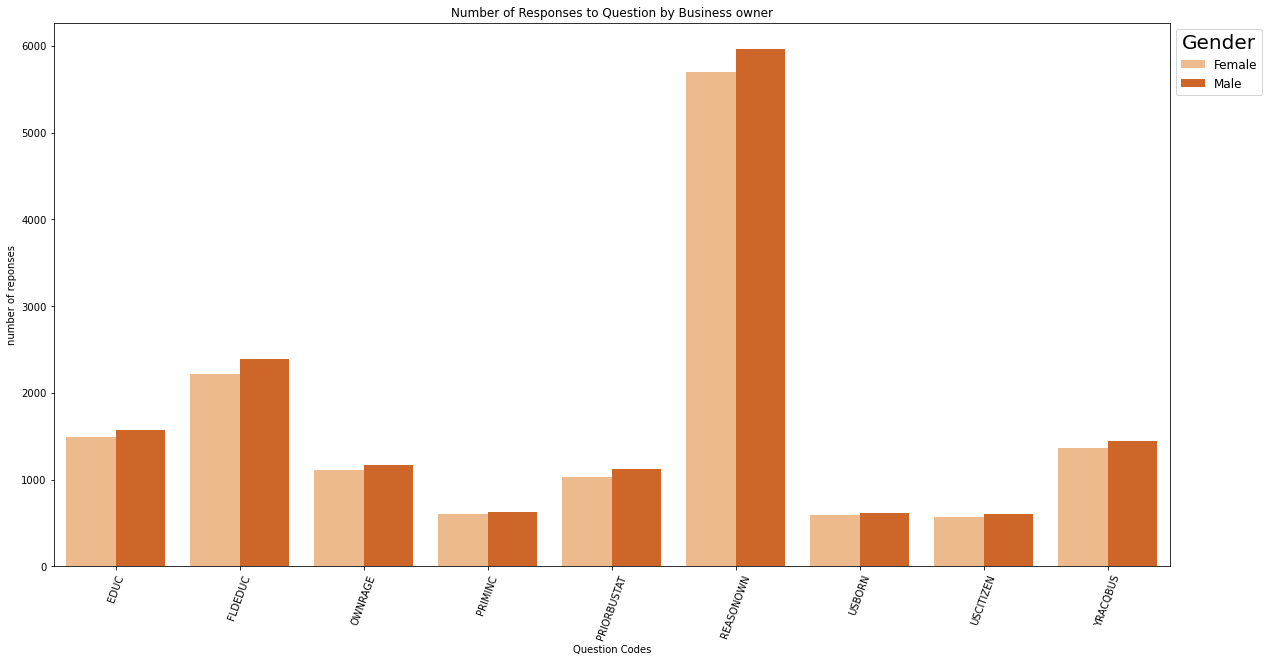

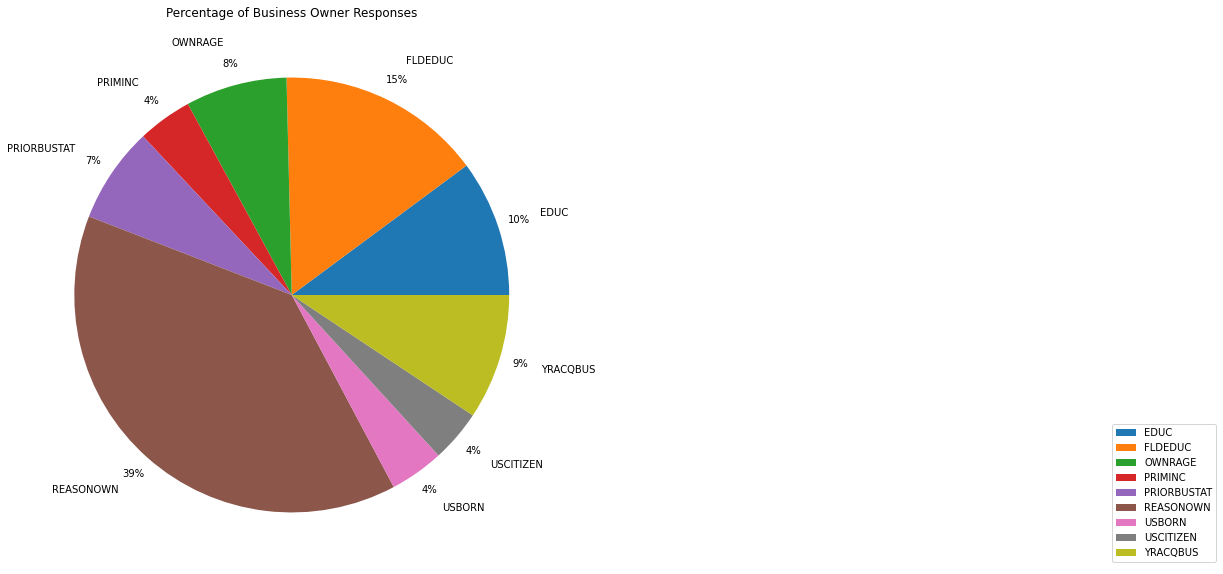

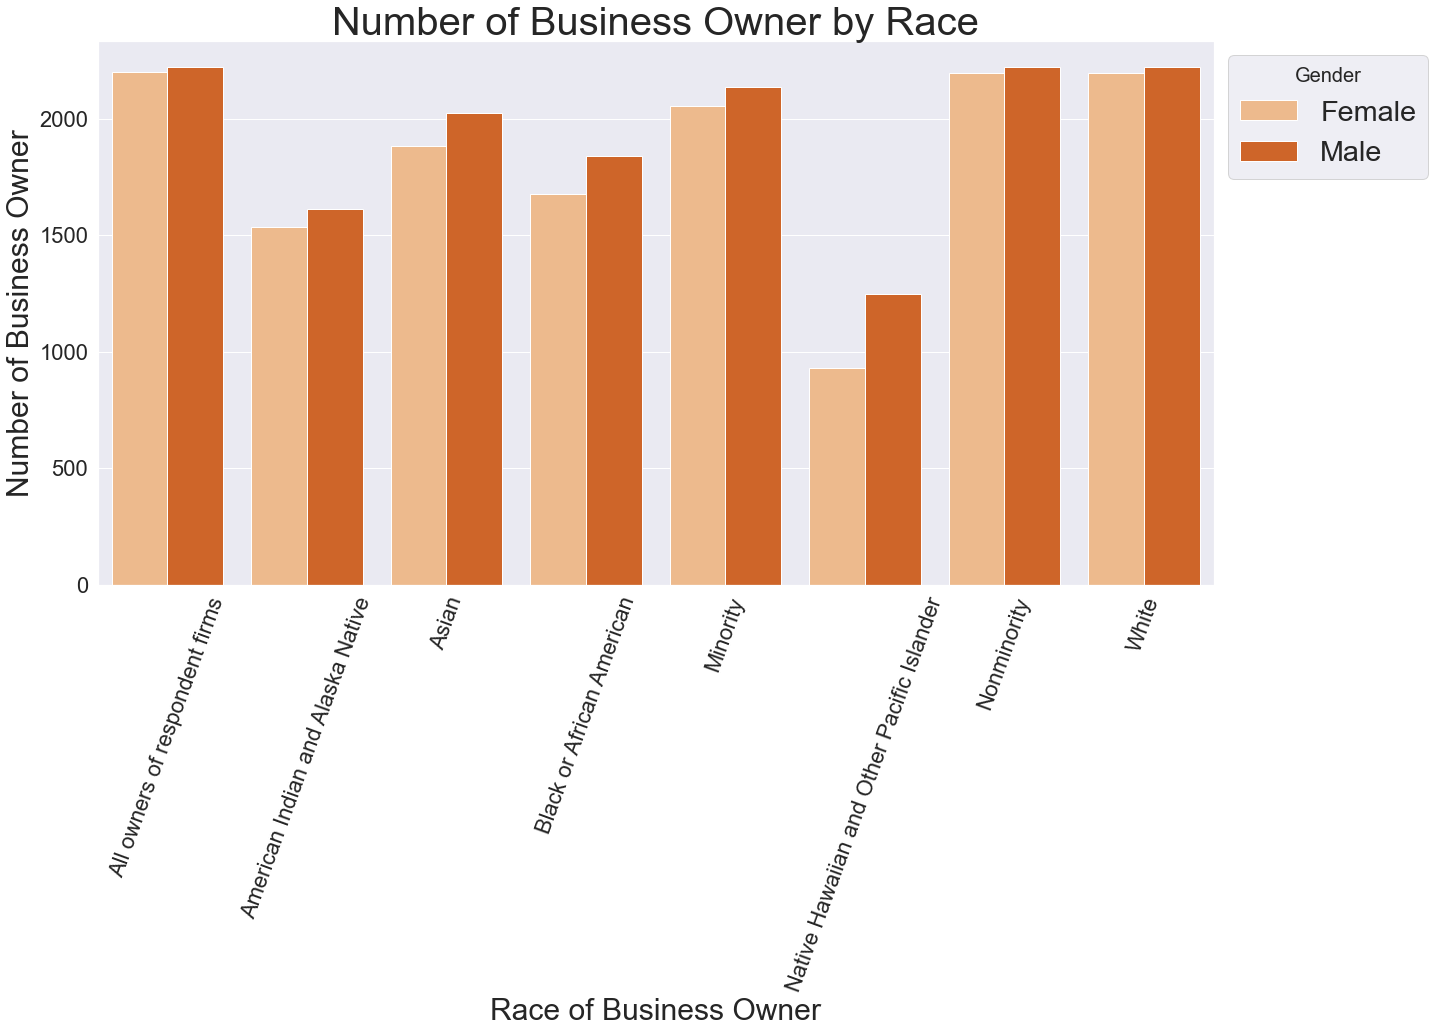

In [19]:
marjeas_visuals()

#### Ryan's Visual Creation Code

In [20]:
def ryans_visuals(comp_sum_df):
    working_df=comp_sum_df
    
    #Dropping unnccessary rows
    working_df = working_df[working_df.race_group_label == 'Total']
    working_df = working_df[working_df.industry == 'Total for all sectors']
    working_df = working_df[working_df.gender == 'Total']
    working_df = working_df[working_df.yibszfi_label != 'Firms with 2 to 3 years in business']
    working_df = working_df[working_df.yibszfi_label != 'Firms with 4 to 5 years in business']
    working_df = working_df[working_df.yibszfi_label != 'Firms with 6 to 10 years in business']
    working_df = working_df[working_df.yibszfi_label != 'Firms with 11 to 15 years in business']
    working_df = working_df[working_df.yibszfi_label != 'Firms with 16 or more years in business']


    #Dropping unneccessary columns
    working_df = working_df.drop(['geo_id','industry_code','industry','race_group_label','gender','state'], axis = 1)
    
    #Getting % of businesses under 2 years old of total
    working_min = working_df.groupby(by = ['name'])[['firmpdemp']].agg('min')
    working_max = working_df.groupby(by = ['name'])[['firmpdemp']].agg('max')
    workingfinal = ((working_min / working_max) * 100)
    
    #Dropping States with nulls/zeroes for under 2 year businesses
    workingfinal = workingfinal[~(workingfinal == 0).all(axis=1)]
    workingfinal.reset_index(inplace=True)
    workingfinal2 = workingfinal
    workingfinal.rename(columns = {'firmpdemp':'% of Firms < Two Years Old'}, inplace = True)
    #State codes for converting to map form
    code = {'Alabama': 'AL',
        'Alaska': 'AK',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'Delaware': 'DE',
        'District of Columbia': 'DC',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY'}
    #Updating states with map code
    workingfinal['Code'] = workingfinal['name'].map(code)
    
    #Map information
    fig = px.choropleth(workingfinal,
                    locations='Code',
                    color='% of Firms < Two Years Old',
                    color_continuous_scale='spectral_r',
                    locationmode='USA-states',
                    scope='usa')
    fig.add_scattergeo(
        locations=workingfinal['Code'],
        locationmode='USA-states',
        text=workingfinal['Code'],
        mode='text')

    fig.update_layout(
        title={'text':'Percentage of Total Businesses Less Than Two Years Old by State',
               'xanchor':'center',
               'yanchor':'top',
               'x':0.5})
    fig
    #Second plot ETL
    working_df=comp_sum_df
    
    #Row removal
    working_df = working_df[working_df.race_group_label == 'Total']
    working_df = working_df[working_df.industry == 'Total for all sectors']
    working_df = working_df[working_df.gender == 'Total']
    working_df = working_df[working_df.yibszfi_label != 'All firms']
    
    #Split to two states
    working_df1 = working_df[working_df.name == 'Florida']
    working_df2 = working_df[working_df.name == 'West Virginia']
    
    #Dropping columns
    working_df1 = working_df1.drop(['geo_id','industry_code','industry','race_group_label','gender','state'], axis = 1)
    working_df2 = working_df2.drop(['geo_id','industry_code','industry','race_group_label','gender','state'], axis = 1)
    
    #Changing from int to float type for aggregates
    working_df2['firmpdemp'] = working_df2['firmpdemp'].astype(float)
    working_df1['firmpdemp'] = working_df1['firmpdemp'].astype(float)
    
    
    #Updating values for average by index
    i = 60339
    while i < 60345:
        working_df1['firmpdemp'][i] = (working_df1['firmpdemp'][i] * .000223532620)
        i = i + 1
    
    i = 40817
    while i < 40822:
        working_df2['firmpdemp'][i] = (working_df2['firmpdemp'][i] * 0.004279356384)
        i = i + 1
    working_df2['firmpdemp'][40900] = (working_df2['firmpdemp'][40900] * 0.004279356384)
    
    #Renaming columns
    working_df1.rename(columns = {'yibszfi_label':'Years in Business', 'name':'State'}, inplace = True)
    working_df2.rename(columns = {'yibszfi_label':'Years in Business', 'name':'State'}, inplace = True)
    
    #Creating pivots for chart
    pivot_df = working_df1.pivot(index='State', columns='Years in Business', values='firmpdemp')
    pivot_df1 = working_df2.pivot(index='State', columns='Years in Business', values='firmpdemp')
    
    #Merging back to one table
    pivot_df2 = pd.concat([pivot_df1, pivot_df], axis = 0)
    
    #Plot info
    ordered_df2 = pivot_df2.loc[:,['Firms with less than 2 years in business','Firms with 2 to 3 years in business','Firms with 4 to 5 years in business','Firms with 6 to 10 years in business','Firms with 11 to 15 years in business','Firms with 16 or more years in business']]
    fig2 = ordered_df2.plot.bar(alpha = 0.4, ylabel= 'Percentage of Firms', title='Years in Business Percent for Florida and West Virginia',stacked=True, figsize=(18,7))
    
    #Third plot ETL
    working_df=comp_sum_df
    
    #Dropping rows
    working_df = working_df[working_df.race_group_label == 'Total']
    working_df = working_df[working_df.industry != 'Total for all sectors']
    working_df = working_df[working_df.gender == 'Total']
    working_df = working_df[working_df.yibszfi_label != 'Firms with 2 to 3 years in business']
    working_df = working_df[working_df.yibszfi_label != 'Firms with 4 to 5 years in business']
    working_df = working_df[working_df.yibszfi_label != 'Firms with 6 to 10 years in business']
    working_df = working_df[working_df.yibszfi_label != 'Firms with 11 to 15 years in business']
    working_df = working_df[working_df.yibszfi_label != 'Firms with 16 or more years in business']
    
    #Dropping columns
    working_df5 = working_df.drop(['geo_id','industry_code','race_group_label','gender','state','name'], axis = 1)
    
    #Splitting
    working_df6 = working_df5[working_df.yibszfi_label != 'All firms']
    working_df7 = working_df5[working_df.yibszfi_label == 'All firms']
    
    #Getting industry sums for each firm attribute
    working_df6 = working_df6.groupby(by = ['industry'])[['firmpdemp']].agg('sum')
    working_df7 = working_df7.groupby(by = ['industry'])[['firmpdemp']].agg('sum')
    
    #Merging with percent
    working_df8 = working_df6 / working_df7 * 100
    
    
    #Renaming columns
    working_df8.rename(columns = {'firmpdemp':'% of Firms < 2 Years Old'}, inplace = True)
    
    #Sort
    working_df8.sort_values(by = ['% of Firms < 2 Years Old'], inplace = True)
    
    #Plot
    ax = working_df8.plot(figsize = (20,10), title = 'Percentage of Total Businesses Less Than Two Years Old by Industry',kind='bar')
    plt.rc('axes',labelsize = 22)
    plt.rc('axes',titlesize = 25)
    plt.rc('xtick', labelsize=20)
    ax.set_ylabel('% of Firms Less than two years old')
    ax.set_xlabel('Industry')
    plt.xticks(rotation = 45, ha='right')
    ax
    return fig

#### Run Ryan's Visuals

In [21]:
# fig = ryans_visuals(comp_sum_df)
# fig

#### Jakes Visual Creation Code

In [22]:
def jakes_visuals():
    #Visual 1: National Firms by Industry and Gender
    
    workingDF = df_collection[5].copy()
    
    #I filtered values to look at number of firms by industries, broken down by gender.
    #To do this I had to filter to look at 'Total' values for race groups and time the firm was open
    workingDF = workingDF[workingDF['firmpdemp'] != 0]
    workingDF = workingDF[workingDF['yibszfi_label'] == 'All firms']
    workingDF = workingDF[workingDF['race_group_label'] == 'Total']
    workingDF = workingDF[workingDF['industry'] != 'Industries not classified']
    workingDF = workingDF[workingDF['gender'] != 'Total']
    workingDF = workingDF[workingDF['industry'] != 'Total for all sectors']
    
    #After filtering, unneeded columns are dropped
    workingDF.drop(['geo_id', 'name', 'industry_code', 'race_group_label', 'yibszfi_label'], axis = 1, inplace = True)
    workingDF = workingDF.sort_values(by = 'firmpdemp', ascending = False)
    
    #This creates labels for the visual. I generated them separate from the visual so I could add a word-wrap
    labels = workingDF['industry'].unique()
    labels = [ '\n'.join(wrap(l, 30)) for l in labels ]
    
    #Making the plot
    plt.figure(figsize=(15, 20))
    ax = sns.barplot(data = workingDF, y = 'industry', x = 'firmpdemp', hue = 'gender')
    ax.set(xlabel ="Number of Firms", ylabel = "Industry", title ='Majority Ownership of US Firms by Industry and Gender')
    ax.set_yticklabels(labels)
    plt.show()
    
    #Visual 2: National Firms by Industry and Minority Status
    workingDF3 = df_collection[5].copy()
    
    #Filtering values to for firm age and gender, here I'm only interested in minority status and industry
    workingDF3 = workingDF3[workingDF3['firmpdemp'] != 0]
    workingDF3 = workingDF3[workingDF3['yibszfi_label'] == 'All firms']
    workingDF3 = workingDF3[workingDF3['gender'] == 'Total']
    workingDF3 = workingDF3[workingDF3['industry'] != 'Industries not classified']
    workingDF3 = workingDF3.query('race_group_label  in ("Nonminority", "Minority")')
    workingDF3 = workingDF3[workingDF3['industry'] != 'Total for all sectors']
    
    #Dropping unneeded columns after using them to filter
    workingDF3.drop(['geo_id', 'name', 'industry_code', 'gender', 'yibszfi_label'], axis = 1, inplace = True)
    workingDF3 = workingDF3.sort_values(by = 'firmpdemp', ascending = False)
    
    #Generating labels for the plot and using word wrap
    labels3 = workingDF3['industry'].unique()
    labels3 = [ '\n'.join(wrap(l, 30)) for l in labels ]
    
    #Making the plot
    plt.figure(figsize=(15, 15))
    ax3 = sns.barplot(data = workingDF3, y = 'industry', x = 'firmpdemp', hue = 'race_group_label')
    ax3.set_yticklabels(labels3)
    ax3.set(xlabel ="Number of Firms", ylabel = "Industry", title ='Majority Ownership of US Firms by Industry and Minority Status')
    plt.legend(loc = 'lower right')
    plt.show()
    
    
    #Visual 3: Ratio of Gender Ownership by State for Construction
    state_df = df_collection[0].copy()
    
    #Filtering columns to control for firm age and race group, 
    #I'm looking at difference in firm ownership by gender and state for the construction industry
    state_df = state_df[state_df['industry'] == 'Construction']
    state_df = state_df[state_df['gender'] != 'Total']
    state_df = state_df[state_df['gender'] != 'Equally male/female']
    state_df = state_df[state_df['race_group_label'] == 'Total']
    state_df = state_df[state_df['yibszfi_label'] == 'All firms']
    
    #Dropping unneeded columns
    state_df.drop(['geo_id','industry', 'race_group_label','yibszfi_label', 'state', 'emp', 'industry_code', 'payann', 'rcppdemp'], axis = 1, inplace=True)
    state_df.sort_values('name', inplace=True)
    
    #I'm breaking the gender column into 2 separate dataframes
    male_df = state_df[state_df['gender'] == 'Male'].copy()
    female_df = state_df[state_df['gender'] == 'Female'].copy()
    male_df.reset_index(inplace=True)
    female_df.reset_index(inplace=True)
    
    #Making a new dataframe with columns for #male-owned firms and #female-owned firms
    newdf = male_df.copy()
    newdf.drop('gender', axis = 1, inplace=True)
    female_df.drop('gender', axis = 1, inplace=True)
    newdf.rename(columns = {'firmpdemp':'Male'}, inplace = True)
    female_df.rename(columns = {'firmpdemp':'Female'}, inplace = True)
    
    #Adding the female-owned firms column
    newdf = newdf.merge(female_df, on = 'name')
    newdf = newdf[newdf['Male'] != 0]
    
    #Generating a new column to find the ratio of female-owned firms to male-owned firms
    newdf = newdf.assign(RatioFemaleToMale=lambda y: (y['Female'] / y['Male']))
    newdf.sort_values('RatioFemaleToMale', ascending = False, inplace = True)
    
    #Drop unneeded columns
    newdf.drop(['Male', 'Female'], axis = 1, inplace = True)
    newdf = newdf.head(16)
    
    #Making the plot
    plt.figure(figsize=(15, 5))
    ax4 = sns.barplot(data = newdf, y = 'name', x = 'RatioFemaleToMale', color = 'orange')
    ax4.set(xlabel ="Ratio of Female Owned Firms to Male Owned Firms", 
    ylabel = "State", title ='Majority Ownership of US Firms by Gender and State')
    plt.show()

#### Run Jakes Visuals

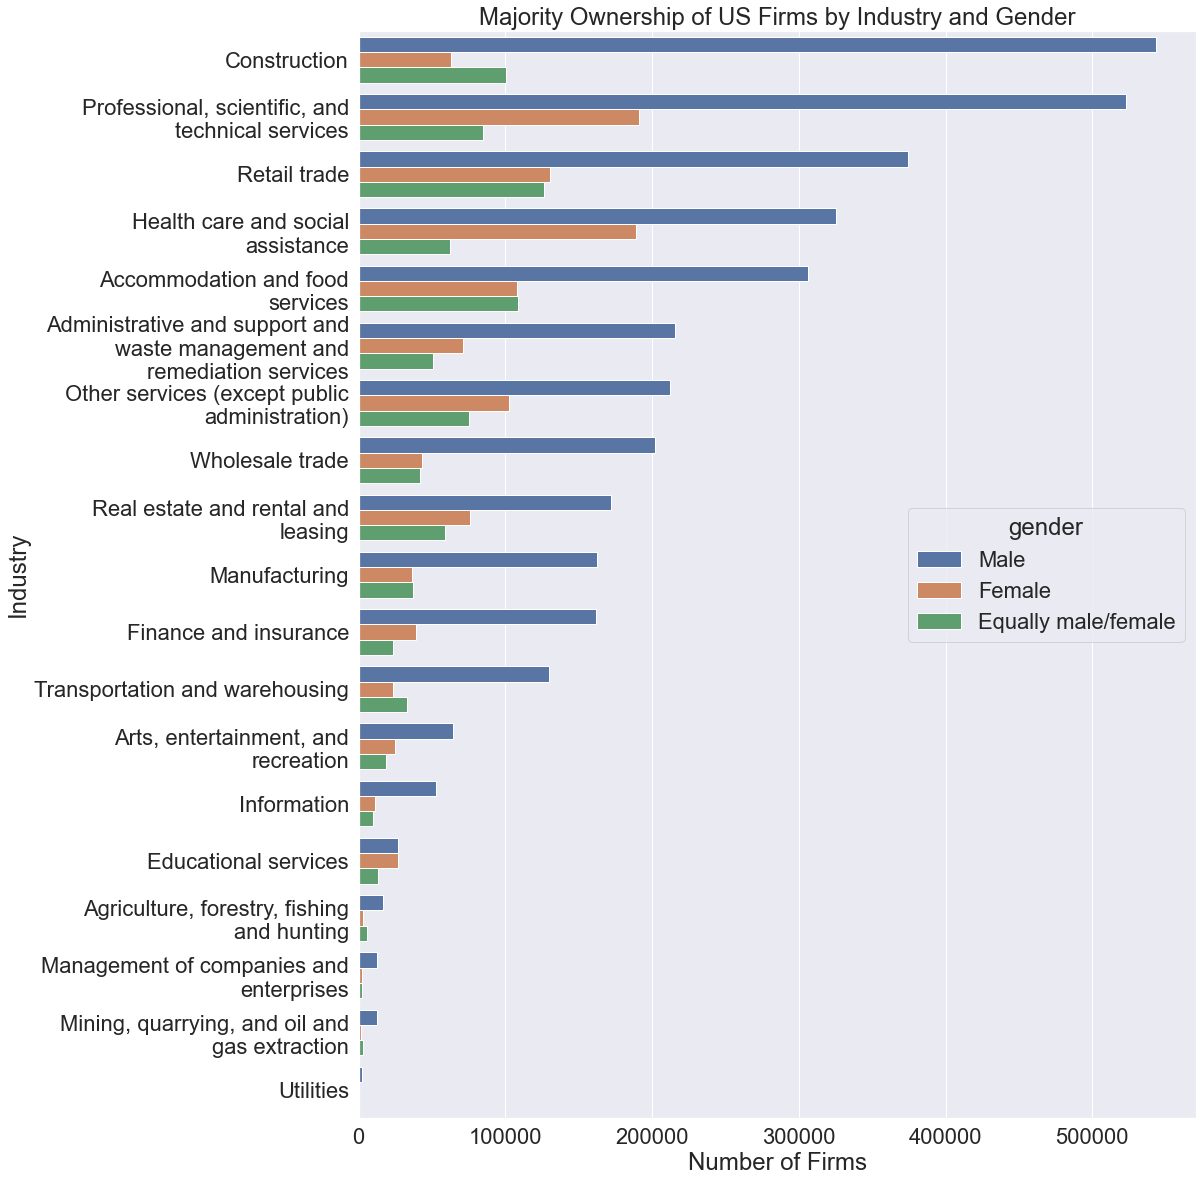

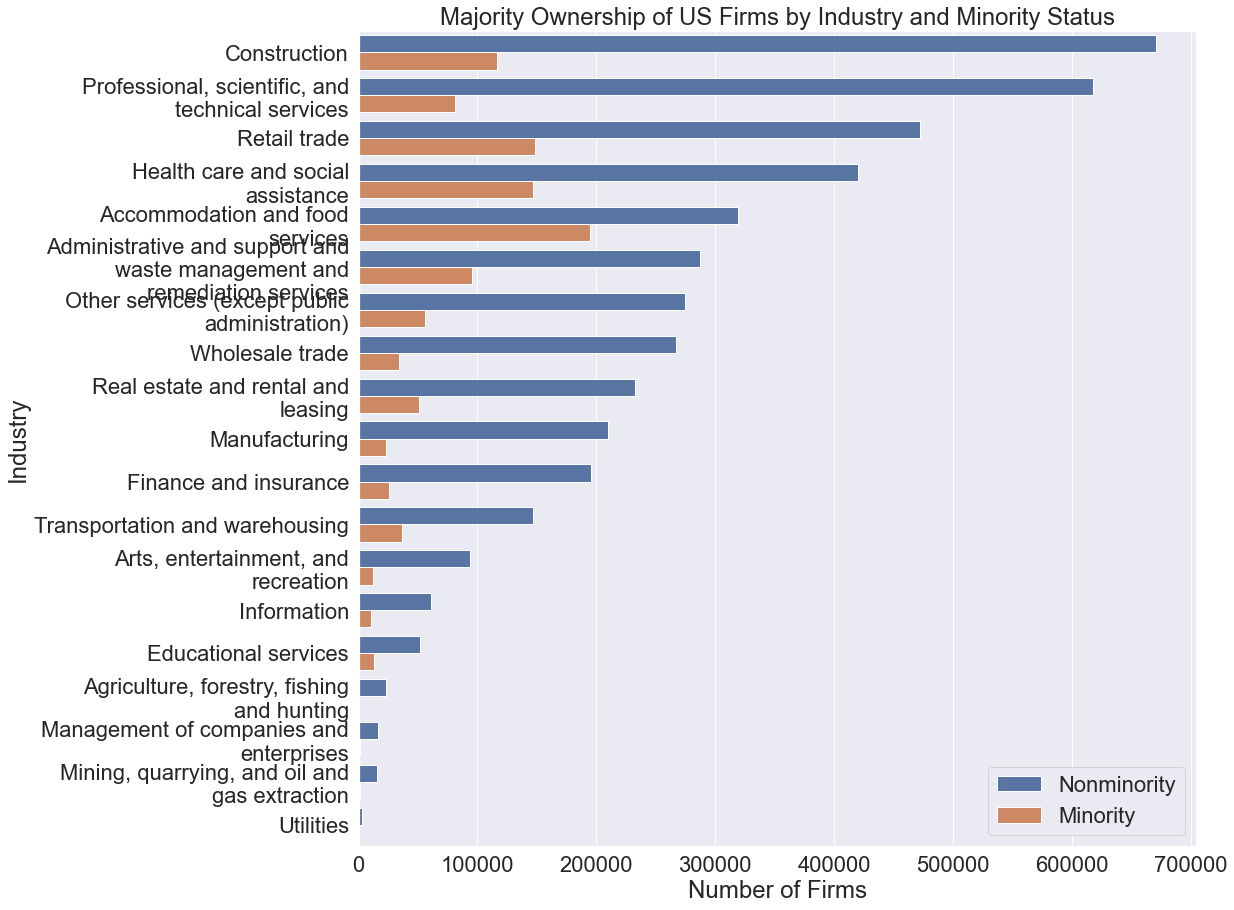

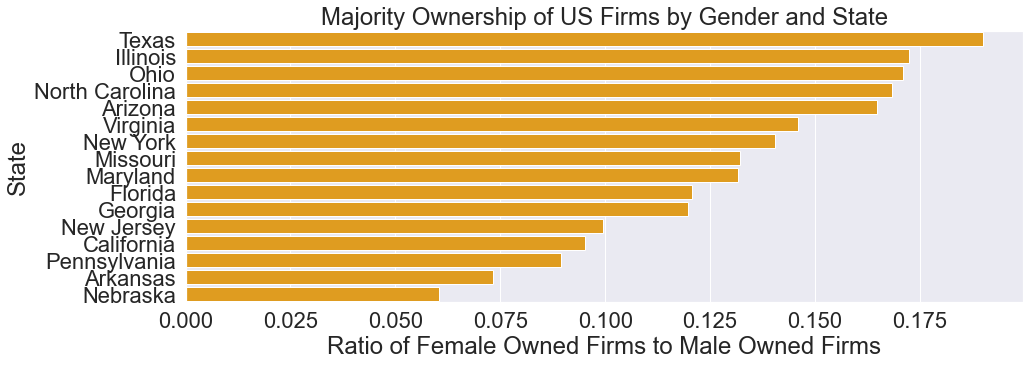

In [23]:
jakes_visuals()